### AI-Based Online Exam Proctoring System
#### Complete Training Pipeline for Cheating Detection

 
**Project:** ensureStudy - AI Proctoring Module  
**Purpose:**  Preparation Notebook

---

### 📋 Table of Contents
1. Introduction & Problem Statement
2. System Architecture Overview
3. Feature Extraction Pipeline
4. Data Loading & Preprocessing
5. Handling Class Imbalance
6. Model Selection & Comparison
7. Hyperparameter Optimization with Optuna
8. Model Training & Evaluation
9. Results Visualization
10. Temporal Models (LSTM/GRU)
11. Conclusion & Future Work

---
## 1. Introduction & Problem Statement

### Why AI-Based Proctoring?

With the rise of online education (especially post-COVID), maintaining exam integrity has become a **critical challenge**. Traditional human proctoring doesn't scale, and students can exploit blind spots.

### Our Solution
We built an **AI-powered proctoring system** that:
- Monitors students in **real-time** using two cameras (face + desk)
- Detects **suspicious behaviors** like looking away, using phones, or unauthorized materials
- Uses **machine learning** to classify cheating vs non-cheating behavior

### Key Features Detected
| Feature | Description | Why It Matters |
|---------|-------------|----------------|
| Face Verification | Is this the registered student? | Prevents impersonation |
| Gaze Direction | Where is the student looking? | Detects looking at notes/phone |
| Head Pose | Pitch, yaw, roll of head | Unusual angles = suspicious |
| Prohibited Objects | Phones, earpieces, chits | Direct cheating evidence |
| Hand Position | Distance from camera | Hiding prohibited items |

---
## 2. System Architecture

```
┌─────────────────┐     ┌─────────────────┐
│   Face Camera   │     │   Desk Camera   │
│   (Front View)  │     │   (Side View)   │
└────────┬────────┘     └────────┬────────┘
         │                       │
         ▼                       ▼
┌─────────────────────────────────────────┐
│         Feature Extraction Layer        │
│  ┌───────────┐  ┌───────────┐  ┌──────┐ │
│  │ MediaPipe │  │   YOLOv11 │  │ Dlib │ │
│  │Face Mesh  │  │  Objects  │  │ Face │ │
│  └───────────┘  └───────────┘  └──────┘ │
└────────────────────┬────────────────────┘
                     │
                     ▼
         ┌───────────────────────┐
         │   22 Numeric Features │
         └───────────┬───────────┘
                     │
                     ▼
┌─────────────────────────────────────────┐
│      Machine Learning Classifier        │
│  ┌─────────┐ ┌─────────┐ ┌───────────┐  │
│  │ XGBoost │ │LightGBM │ │RandomForest│ │
│  └─────────┘ └─────────┘ └───────────┘  │
└────────────────────┬────────────────────┘
                     │
                     ▼
              ┌──────────────┐
              │ Cheating: 0/1│
              └──────────────┘
```

---
## 3. Setup & Imports

Let's start by importing all the libraries we need.

In [5]:
# Core libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

# Gradient Boosting Models
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek

# Hyperparameter Optimization
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Model persistence
import joblib

print("✅ All libraries imported successfully!")
print(f"📅 Notebook run on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Notebook run on: 2025-12-30 10:51:48


---
## 4. Data Loading & Exploration

### 4.1 Understanding Our Features

Our dataset contains **22 features** extracted from video frames:

| Feature | Type | Description |
|---------|------|-------------|
| `verification_result` | Binary | Face matches registered ID (1) or not (0) |
| `num_faces` | Integer | Number of faces detected (should be 1) |
| `iris_pos` | Categorical | Eye direction: center(0), left(1), right(2) |
| `iris_ratio` | Float | Ratio of iris position (0.5 = centered) |
| `mouth_zone` | Categorical | Mouth openness: GREEN(0) to RED(3) |
| `mouth_area` | Float | Area of mouth region in pixels |
| `x/y/z_rotation` | Float | Head pose angles (pitch/yaw/roll) |
| `gaze_direction` | Categorical | forward(0), left(1), right(2), up(3), down(4) |
| `gaze_zone` | Categorical | white(0), yellow(1), red(2) - risk level |
| `watch`, `headphone`, etc. | Binary | Detected prohibited objects |
| `H-Distance`, `F-Distance` | Float | Hand distance from camera |

In [ ]:

TRAIN_DIR = "../../new2_csv/train/"  # Directory with training CSVs
TEST_DIR = "../../new2_csv/test/"    # Directory with test CSVs

# Load all CSV files from directories
def load_csvs_from_directory(directory):
    """Load and combine all CSVs from a directory."""
    dfs = []
    if not os.path.exists(directory):
        print(f"⚠️ Directory not found: {directory}")
        return None
    
    for file in sorted(os.listdir(directory)):
        if file.endswith('.csv'):
            path = os.path.join(directory, file)
            df = pd.read_csv(path)
            print(f"  📄 Loaded {file}: {len(df)} samples")
            dfs.append(df)
    
    if not dfs:
        return None
    return pd.concat(dfs, ignore_index=True)

print("📂 Loading Training Data...")
train_df = load_csvs_from_directory(TRAIN_DIR)

print("\n📂 Loading Test Data...")
test_df = load_csvs_from_directory(TEST_DIR)

if train_df is not None:
    print(f"\n✅ Total training samples: {len(train_df)}")
    print(f"✅ Total test samples: {len(test_df) if test_df is not None else 0}")

📂 Loading Training Data...
  📄 Loaded Train_Video1_processed.csv: 2835 samples
  📄 Loaded Train_Video2_processed.csv: 1947 samples

📂 Loading Test Data...
  📄 Loaded Test_Video1_processed.csv: 709 samples
  📄 Loaded Test_Video2_processed.csv: 487 samples

✅ Total training samples: 4782
✅ Total test samples: 1196


In [7]:
# Let's explore the training data
print("📊 Dataset Shape:", train_df.shape)
print("\n📋 Column Names:")
print(train_df.columns.tolist())

print("\n📈 First 5 rows:")
train_df.head()

📊 Dataset Shape: (4782, 26)

📋 Column Names:
['timestamp', 'verification_result', 'num_faces', 'iris_pos', 'iris_ratio', 'mouth_zone', 'mouth_area', 'x_rotation', 'y_rotation', 'z_rotation', 'radial_distance', 'gaze_direction', 'gaze_zone', 'watch', 'headphone', 'closedbook', 'earpiece', 'cell phone', 'openbook', 'chits', 'sheet', 'H-Distance', 'F-Distance', 'split', 'video', 'is_cheating']

📈 First 5 rows:


,timestamp,verification_result,num_faces,iris_pos,iris_ratio,mouth_zone,mouth_area,x_rotation,y_rotation,z_rotation,...,earpiece,cell phone,openbook,chits,sheet,H-Distance,F-Distance,split,video,is_cheating
0,0-00-52.900000,1,1.0,0,0.551024,1,169.0,0.0,0.0,0.0,...,0,1,0,0,0,90.553851,10000.0,Train,Video1,1
1,0-00-15.400000,1,1.0,0,0.456669,0,26.5,0.0,0.0,0.0,...,0,0,0,0,0,10000.000000,10000.0,Train,Video1,1
2,0-00-08.300000,1,1.0,0,0.423347,0,65.0,0.0,0.0,0.0,...,0,0,0,0,0,10000.000000,10000.0,Train,Video1,1
3,0-01-36.150000,0,0.0,-1,0.000000,-1,0.0,0.0,0.0,0.0,...,0,1,0,0,0,122.723266,10000.0,Train,Video1,1
4,0-00-32.900000,1,1.0,0,0.458967,0,97.0,0.0,0.0,0.0,...,0,0,0,0,0,10000.000000,10000.0,Train,Video1,1


🎯 Target Variable Distribution:
is_cheating
1    2835
0    1947
Name: count, dtype: int64

📊 Cheating Rate: 59.28%


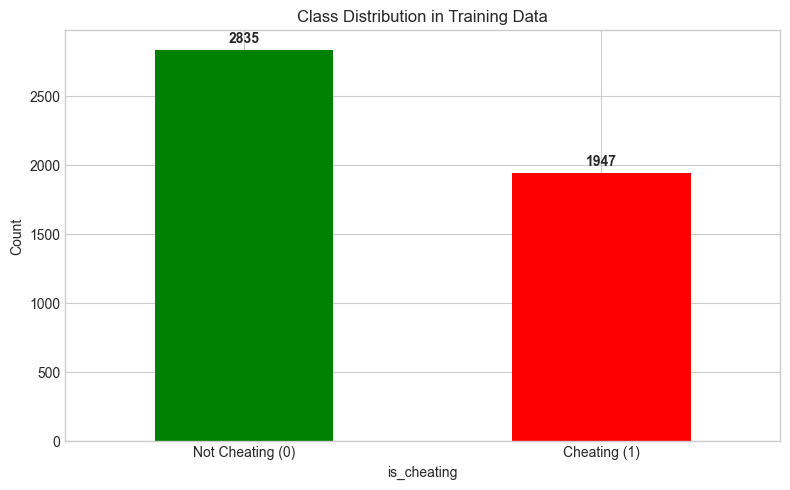


⚖️ Imbalance Ratio (Non-Cheating:Cheating): 0.7:1


In [8]:
# Check class distribution - THIS IS CRITICAL!
print("🎯 Target Variable Distribution:")
print(train_df['is_cheating'].value_counts())
print(f"\n📊 Cheating Rate: {train_df['is_cheating'].mean():.2%}")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
train_df['is_cheating'].value_counts().plot(kind='bar', color=['green', 'red'], ax=ax)
ax.set_xticklabels(['Not Cheating (0)', 'Cheating (1)'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Class Distribution in Training Data')
for i, v in enumerate(train_df['is_cheating'].value_counts()):
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate imbalance ratio
counts = train_df['is_cheating'].value_counts()
imbalance_ratio = counts[0] / counts[1] if 1 in counts.index else 0
print(f"\n⚖️ Imbalance Ratio (Non-Cheating:Cheating): {imbalance_ratio:.1f}:1")

### 4.2 Why Class Imbalance Matters

 *Why is class imbalance a problem?*

**Answer:**
- If 95% of samples are "not cheating", a model can achieve 95% accuracy by always predicting "not cheating"
- But this is useless! We NEED to catch cheaters.
- We use **SMOTE** (Synthetic Minority Over-sampling Technique) to balance classes
- SMOTE creates *synthetic* cheating samples by interpolating between real ones

---
## 5. Data Preprocessing

Before training, we need to:
1. Remove non-feature columns (timestamp, video name, etc.)
2. Handle missing values
3. Scale features (optional for tree-based models)
4. Split into train/test sets

In [9]:
# Columns to remove (not features)
COLUMNS_TO_DROP = ['timestamp', 'is_cheating', 'split', 'video']

def prepare_features(df):
    """Prepare features and target from dataframe."""
    # Separate features and target
    X = df.drop(columns=[col for col in COLUMNS_TO_DROP if col in df.columns])
    y = df['is_cheating']
    
    # Handle missing values with median (robust to outliers)
    X = X.fillna(X.median())
    
    return X, y

# Prepare training features
X_train_full, y_train_full = prepare_features(train_df)

# Prepare test features (if available)
if test_df is not None:
    X_test, y_test = prepare_features(test_df)
else:
    # If no external test set, split training data
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_train_full, y_train_full, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train_full  # Maintain class ratio
    )

print(f"✅ Training features shape: {X_train_full.shape}")
print(f"✅ Test features shape: {X_test.shape}")
print(f"\n📋 Feature columns ({len(X_train_full.columns)}):")
print(X_train_full.columns.tolist())

✅ Training features shape: (4782, 22)
✅ Test features shape: (1196, 22)

📋 Feature columns (22):
['verification_result', 'num_faces', 'iris_pos', 'iris_ratio', 'mouth_zone', 'mouth_area', 'x_rotation', 'y_rotation', 'z_rotation', 'radial_distance', 'gaze_direction', 'gaze_zone', 'watch', 'headphone', 'closedbook', 'earpiece', 'cell phone', 'openbook', 'chits', 'sheet', 'H-Distance', 'F-Distance']


---
## 6. Handling Class Imbalance with SMOTE

* *What is SMOTE and why use it?*

**Answer:**
- **SMOTE** = Synthetic Minority Over-sampling TEchnique
- Creates NEW synthetic samples of the minority class
- Works by finding k-nearest neighbors and interpolating between them
- Better than simple duplication (which causes overfitting)

**Why Borderline-SMOTE?**
- Regular SMOTE creates samples everywhere
- Borderline-SMOTE only creates samples near the decision boundary
- More useful for helping the model learn the "hard" cases

In [ ]:
def apply_smote(X, y, method='borderline_smote'):
    """
    Apply SMOTE to balance classes.
    
    Methods:
    - 'smote': Regular SMOTE
    - 'borderline_smote': Focus on boundary samples
    - 'smote_tomek': SMOTE + remove Tomek links (noisy samples)
    """
    print(f" Applying {method.upper()}...")
    print(f"   Before: {np.bincount(y)}")
    
    # Choose k_neighbors based on minority class size
    minority_count = min(np.bincount(y))
    k_neighbors = min(5, minority_count - 1)  # Avoid errors with small datasets
    
    if method == 'smote':
        sampler = SMOTE(random_state=42, k_neighbors=k_neighbors)
    elif method == 'borderline_smote':
        sampler = BorderlineSMOTE(random_state=42, k_neighbors=k_neighbors)
    elif method == 'smote_tomek':
        sampler = SMOTETomek(random_state=42)
    else:
        print("   Unknown method, returning original data")
        return X, y
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    print(f"   After:  {np.bincount(y_resampled)}")
    
    return X_resampled, y_resampled

# Apply SMOTE to training data
X_train_balanced, y_train_balanced = apply_smote(X_train_full, y_train_full, method='borderline_smote')

⚖️ Applying BORDERLINE_SMOTE...
   Before: [1947 2835]
   After:  [2835 2835]


---
## 7. Model Selection: Why These Models?

### 7.1 Model Comparison

| Model | Pros | Cons | Best For |
|-------|------|------|----------|
| **XGBoost** | Fast, handles missing values, great accuracy | Can overfit, many hyperparameters | Tabular data, competitions |
| **LightGBM** | Faster than XGBoost, lower memory | Sensitive to small datasets | Large datasets |
| **Random Forest** | Robust, less tuning needed | Slower, less accurate | Baseline, interpretability |

### 7.2 Why NOT Deep Learning?

*Why use XGBoost instead of Neural Networks?*

**Answer:**
1. **Tabular data** - Neural networks excel at images/text, not tables
2. **Interpretability** - We can see feature importance in XGBoost
3. **Data size** - We don't have millions of samples
4. **Training time** - XGBoost trains in seconds, not hours
5. **No GPU required** - Runs on any machine

In [11]:
# Split balanced data for validation during training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_train_balanced
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 4536 samples
Validation set: 1134 samples
Test set: 1196 samples


---
## 8. Hyperparameter Optimization with Optuna

*What is Optuna and why use it?*

**Answer:**
- Optuna is a **hyperparameter optimization framework**
- Uses **Bayesian optimization** (smarter than random/grid search)
- Learns from past trials to suggest better parameters
- Can prune bad trials early (saves time)

In [12]:
def objective_xgboost(trial):
    """
    Optuna objective function for XGBoost hyperparameter tuning.
    Returns AUC score to maximize.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'tree_method': 'hist'  # Fast histogram method
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    
    # Evaluate on validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    return auc

# Run optimization (reduce n_trials for quick testing)
print("🔍 Running Optuna hyperparameter search for XGBoost...")
print("   (This may take a few minutes)")

study = optuna.create_study(direction='maximize', study_name='xgboost_tuning')
study.optimize(objective_xgboost, n_trials=50, show_progress_bar=True)

print(f"\n✅ Best AUC: {study.best_value:.4f}")
print(f"📊 Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

🔍 Running Optuna hyperparameter search for XGBoost...
   (This may take a few minutes)


  0%|          | 0/50 [00:00<?, ?it/s]


✅ Best AUC: 0.9204
📊 Best parameters:
   n_estimators: 323
   max_depth: 8
   learning_rate: 0.05504949886309076
   subsample: 0.9784282449339624
   colsample_bytree: 0.8392696084304611
   min_child_weight: 2
   gamma: 0.3233260836446692
   reg_alpha: 0.12418270619000707
   reg_lambda: 0.8789250728184886


---
## 9. Training the Final Model

In [13]:
# Train final model with best parameters
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42,
    'tree_method': 'hist'
})

print("🏋️ Training final XGBoost model...")
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_balanced, y_train_balanced)

print("✅ Model trained successfully!")

🏋️ Training final XGBoost model...
✅ Model trained successfully!


---
## 10. Model Evaluation

### 10.1 Metrics Explanation

| Metric | What it measures | Good for proctoring? |
|--------|------------------|----------------------|
| **Accuracy** | Overall correct predictions | ❌ Misleading with imbalanced data |
| **Precision** | Of predicted cheaters, how many are real? | ⚠️ High = fewer false accusations |
| **Recall** | Of real cheaters, how many did we catch? | ✅ HIGH is critical! |
| **F1 Score** | Balance of Precision & Recall | ✅ Good overall metric |
| **AUC-ROC** | Model's ability to distinguish classes | ✅ Best for ranking risk |

In [14]:
# Make predictions on test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate metrics
auc_score = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print("="*50)
print("📊 TEST SET EVALUATION RESULTS")
print("="*50)
print(f"\n🎯 AUC-ROC Score: {auc_score:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Cheating', 'Cheating']))

📊 TEST SET EVALUATION RESULTS

🎯 AUC-ROC Score: 0.9131
🎯 F1 Score: 0.8707

📋 Classification Report:
              precision    recall  f1-score   support

Not Cheating       0.80      0.84      0.82       487
    Cheating       0.89      0.85      0.87       709

    accuracy                           0.85      1196
   macro avg       0.84      0.85      0.85      1196
weighted avg       0.85      0.85      0.85      1196



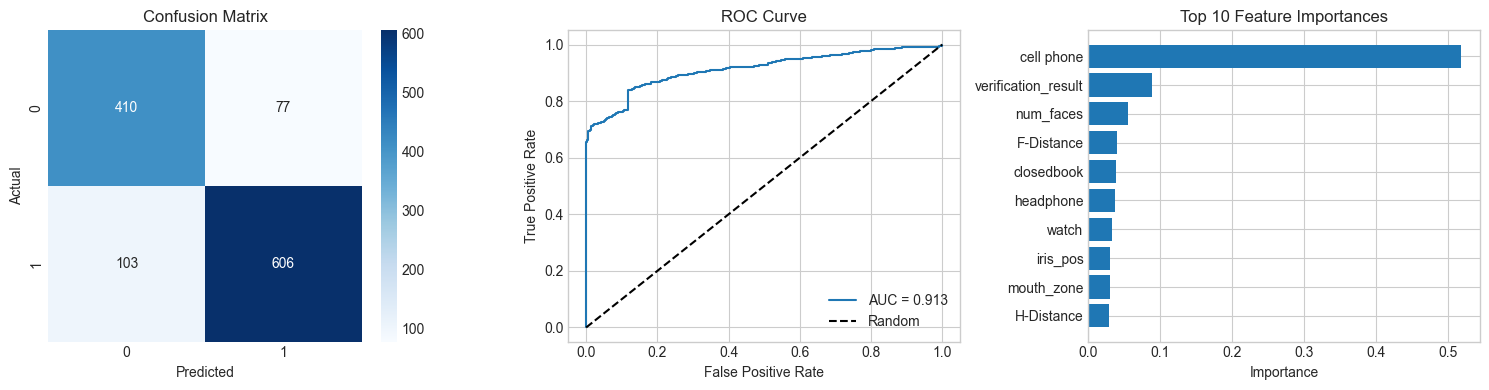

In [15]:
# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

# 3. Feature Importance
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[2].barh(feat_imp['feature'], feat_imp['importance'])
axes[2].set_xlabel('Importance')
axes[2].set_title('Top 10 Feature Importances')

plt.tight_layout()
plt.show()

---
## 11. Save the Model

In [16]:
# Save the trained model
MODEL_DIR = '../Models_new/'
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = os.path.join(MODEL_DIR, f'xgboost_cheating_model_{timestamp}.pkl')

# Save model and metadata
metadata = {
    'feature_names': list(X_train.columns),
    'best_params': best_params,
    'auc_score': auc_score,
    'training_timestamp': timestamp
}

joblib.dump(final_model, model_path)
joblib.dump(metadata, model_path.replace('.pkl', '_metadata.pkl'))

print(f"✅ Model saved to: {model_path}")
print(f"✅ Metadata saved to: {model_path.replace('.pkl', '_metadata.pkl')}")

✅ Model saved to: ../Models_new/xgboost_cheating_model_20251230_105224.pkl
✅ Metadata saved to: ../Models_new/xgboost_cheating_model_20251230_105224_metadata.pkl


---
## 12. Temporal Models (LSTM/GRU) - For Sequence Data

** Question:** *When would you use LSTM instead of XGBoost?*

**Answer:**
- XGBoost treats each frame **independently**
- LSTM/GRU can model **sequences** of frames
- Useful when cheating behavior unfolds over time (e.g., gradually looking at phone)

### LSTM Architecture
```
Input: (batch, seq_len, features) → e.g., (32, 30, 22) = 30 frames of 22 features
                 │
                 ▼
        ┌─────────────────┐
        │  LSTM (2 layers)│  ← Learns temporal patterns
        │  hidden_size=128│
        └────────┬────────┘
                 │
                 ▼
        ┌─────────────────┐
        │   LayerNorm     │
        │   + Dropout     │
        └────────┬────────┘
                 │
                 ▼
        ┌─────────────────┐
        │  FC: 128 → 32   │
        │  FC: 32 → 1     │
        └────────┬────────┘
                 │
                 ▼
        Output: Cheating probability
```

In [17]:
import torch
import torch.nn as nn

class LSTMCheatDetector(nn.Module):
    """
    LSTM-based sequence classifier for cheating detection.
    
    Why LSTM over GRU?
    - LSTM has a separate cell state (better for longer sequences)
    - Forget gate helps ignore irrelevant past frames
    - More parameters = more expressive (but slower)
    
    Why 2 layers?
    - First layer: learns basic temporal patterns
    - Second layer: learns higher-level abstractions
    """
    
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        
        # LSTM encoder
        self.lstm = nn.LSTM(
            input_size=input_size,      # Number of features (22)
            hidden_size=hidden_size,    # Hidden state size
            num_layers=num_layers,      # Stack 2 LSTMs
            batch_first=True,           # Input: (batch, seq, features)
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Normalization + Dropout
        self.layernorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        
        # Classifier head
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        
        # Process sequence through LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        # h_n shape: (num_layers, batch, hidden_size)
        
        # Take last layer's hidden state
        last_hidden = h_n[-1]  # (batch, hidden_size)
        
        # Normalize and dropout
        x = self.layernorm(last_hidden)
        x = self.dropout(x)
        
        # Classify
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x.squeeze(1)  # (batch,)

# Example usage
input_size = 22  # Number of features
model = LSTMCheatDetector(input_size)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

LSTMCheatDetector(
  (lstm): LSTM(22, 128, num_layers=2, batch_first=True, dropout=0.3)
  (layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

📊 Total parameters: 214,337
📊 Trainable parameters: 214,337


---
## 13. Conclusion &  Questions

### Key Takeaways

1. **Feature Extraction**: Used MediaPipe (face/hands) + YOLO (objects) + Dlib (face verification)
2. **Class Imbalance**: Handled with BorderlineSMOTE - creates synthetic minority samples near decision boundary
3. **Model Choice**: XGBoost/LightGBM for tabular data (faster, more interpretable than deep learning)
4. **Hyperparameter Tuning**: Optuna with Bayesian optimization (smarter than grid search)
5. **Evaluation**: AUC-ROC primary metric (better than accuracy for imbalanced data)

### Common  Questions

| Question | Answer |
|----------|--------|
| Why XGBoost over Neural Networks? | Tabular data, interpretability, smaller dataset, faster training |
| What is SMOTE? | Synthetic Minority Over-sampling - creates artificial minority samples |
| Why AUC over Accuracy? | Accuracy is misleading with imbalanced classes |
| What does a 0.95 AUC mean? | 95% chance of ranking a random cheater higher than a non-cheater |
| When would you use LSTM? | When temporal sequence matters (gradual behavior changes) |
| What is the forget gate in LSTM? | Decides what information to discard from memory |
| Why use Optuna? | Bayesian optimization is smarter than random/grid search |